In [7]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

S = 512

def transpose(A):
    N, M = A.shape
    i, j = tf.indices([M, N])
    return A[j, i] * 1.0

def matmul():
    A = tf.input([-1, -1], tf.float32)
    N, M = A.shape
    B = tf.input([M, -1], tf.float32)
    K = B.shape[1]
        
    Bt = transpose(B)
        
    #C = tf.zeros([N, K])
    #i, j, k = tf.indices([N, K, M])
    #tf.scatterAdd(C[i, j], A[i, k] * Bt[j, k])
        
    C = tf.buffer([N, K])
        
    i, j = C.indices
        
    s = tf.zeros([N, K], tf.float32)
    def loop_body(k):
        s.set(s + A[i, k] * Bt[j, k])
         
    tf.loop(loop_body, 0, M, 1)
        
    C[i, j] = s
        
    return [C]

mmul = tf.compile(matmul)

matmul:
  Kernel count: 1
  Intermediate buffers: 0
  Lines of generated code: 311



In [8]:
Anp = np.random.rand(64, 32).astype(np.float32)
Bnp = np.random.rand(32, 48).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)
C, = mmul(A, B)

Cnp = C.numpy

#compare to numpy
Cnp2 = Anp @ Bnp

print(Cnp)
print(Cnp2)

Cerror = np.linalg.norm(Cnp - Cnp2) / np.linalg.norm(Cnp2)
print("Error:", Cerror)


[[ 6.9058127  6.4943595  9.217809  ...  7.5131345  7.7720985  9.155246 ]
 [ 6.8360023  7.144544   8.069699  ...  6.553105   8.503913   7.3255916]
 [ 7.1090093  6.9138517  7.860469  ...  7.288773   7.9731975  7.425622 ]
 ...
 [ 8.669722   8.078477   9.995454  ...  8.298476  10.113775  10.026747 ]
 [ 7.366826   5.9925632  7.5778313 ...  5.91198    8.036941   7.806314 ]
 [ 6.890036   6.2021017  8.088246  ...  6.2884345  7.896097   7.7949963]]
[[ 6.905813   6.494359   9.21781   ...  7.5131345  7.7720985  9.155243 ]
 [ 6.836003   7.1445446  8.069699  ...  6.553105   8.503914   7.325592 ]
 [ 7.1090093  6.9138527  7.86047   ...  7.2887735  7.973198   7.4256215]
 ...
 [ 8.669722   8.078476   9.995455  ...  8.298476  10.113776  10.026749 ]
 [ 7.3668265  5.9925613  7.5778313 ...  5.9119797  8.036941   7.8063145]
 [ 6.8900356  6.202101   8.088247  ...  6.2884355  7.896097   7.794996 ]]
Error: 6.650822e-08


In [9]:
Anp = np.random.rand(S, S).astype(np.float32)
Bnp = np.random.rand(S, S).astype(np.float32)

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

def TestFunc(f1, max_time):
    t0 = time.time()
    i = 0
    while time.time() - t0 < max_time:
        f1()
        i += 1
    return (time.time() - t0) / i

# Performance test
def TensorFrost():
    C, = mmul(A, B)

def Numpy():
    Cnp2 = Bnp @ Anp

np_time = TestFunc(Numpy, 10)
print("Numpy: ", np_time)

tf_time = TestFunc(TensorFrost, 10)
print("TensorFrost: ", tf_time)

print("TF/NP: ", tf_time / np_time)

Numpy:  0.001166752319104501
TensorFrost:  0.02092698927204978
TF/NP:  17.936102572405034


In [10]:
# Test performance with different matrix sizes

def test_size(S):
    Anp = np.random.rand(S, S).astype(np.float32)
    Bnp = np.random.rand(S, S).astype(np.float32)

    A = tf.tensor(Anp)
    B = tf.tensor(Bnp)

    # Performance test
    def TensorFrost():
        C, = mmul(A, B)
    
    def Numpy():
        Cnp2 = Bnp @ Anp

    tf_time = TestFunc(TensorFrost, 1)
    np_time = TestFunc(Numpy, 1)

    return tf_time, np_time

sizes = [2**i for i in range(4, 12)]
tf_times = []
np_times = []

for S in sizes:
    tf_time, np_time = test_size(S)
    tf_times.append(tf_time)
    np_times.append(np_time)

    

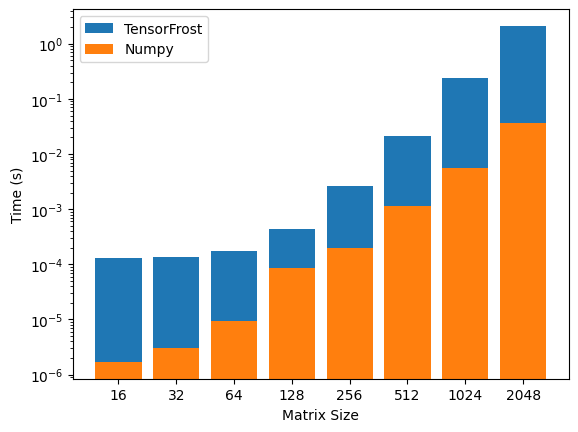

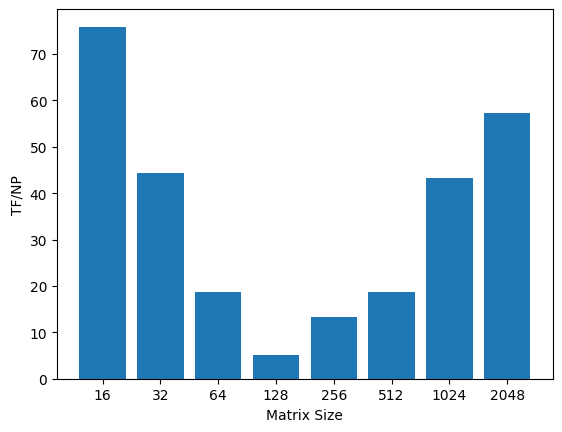

[0.0001287085086900501, 0.00013368753894325185, 0.00017220010690135827, 0.0004459055349788564, 0.0026020780786291347, 0.021295274297396343, 0.2431281566619873, 2.1081931591033936]
[1.6962068703233939e-06, 3.0172829244536927e-06, 9.184345020662572e-06, 8.675855203770168e-05, 0.0001946888545143929, 0.0011394678324393097, 0.0056134935197883476, 0.03674100978033883]


In [11]:
# Bar plot
size_str = [str(s) for s in sizes]
plt.bar(size_str, tf_times, label="TensorFrost")
plt.bar(size_str, np_times, label="Numpy")
plt.legend()
plt.xlabel("Matrix Size")
plt.ylabel("Time (s)")
plt.yscale("log")
plt.show()

# Bar plot with ratio
size_str = [str(s) for s in sizes]
plt.bar(size_str, [tf_times[i] / np_times[i] for i in range(len(sizes))])
plt.xlabel("Matrix Size")
plt.ylabel("TF/NP")
plt.show()


print(tf_times)
print(np_times)